<a href="https://colab.research.google.com/github/RannellRobertson/Python-Deep-Learning-Projects/blob/main/Presence_Custom_CNN_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

In [3]:
from torch.nn import functional as F

#@title Defining CNN Architecture
class CNN(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):

        # Initialize the class as a subclass of nn.Module
        super(CNN, self).__init__()

        self.hidden_units = hidden_units

        # First convolutional layer
        self.conv1 = nn.Conv2d(input_shape, hidden_units, 2)  # 3 input channels, n hidden units, 2x2 kernel

        # First max pooling layer
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2

        # Second convolutional layer
        self.conv2 = nn.Conv2d(hidden_units, hidden_units, 2)  # n hidden units, n hidden units, 2x2 kernel

        # Second max pooling layer
        self.pool2 = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2

        # 3 Fully connected layers
        # Linear transformation to 120-dimensional space
        self.fc1 = nn.Linear(hidden_units * 55 * 55, 120)  # Flattening the input, hidden_units*27*27 input features, 120 output features

        # Linear transformation to 84-dimensional space
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features

        # Linear transformation to 10-dimensional space (output classes)
        self.fc3 = nn.Linear(84, output_shape)  # 84 input features, 10 output features (number of classes)

    def forward(self, x):
        # Operation 1: First convolutional layer with ReLU activation and max pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        # print(x.shape)

        # Operation 2: Second convolutional layer with ReLU activation and max pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        # print(x.shape)

        # Operation 3: Flattened Layer: Reshape for fully connected layer
        x = x.view(-1, self.hidden_units * 55 * 55)

        # Operation 4: First fully connected layer with ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Operation 5: Second fully connected layer with ReLU activation
        x = self.fc2(x)
        x = F.relu(x)

        # Operation 6: Output layer (fully connected) with raw scores for each class
        x = self.fc3(x)

        return x


In [4]:
#@title Defining Custom CNN Architecture
class PresenceCNN(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super(PresenceCNN, self).__init__()

    self.conv1_layer = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                           out_channels=hidden_units,
                           kernel_size=2,
                           stride=1,
                           padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv2_layer = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                           out_channels=hidden_units,
                           kernel_size=2,
                           stride=1,
                           padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv3_layer = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                           out_channels=hidden_units,
                           kernel_size=2,
                           stride=1,
                           padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*27*27, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, output_shape)
    )


  def forward(self, x):
    # x = self.conv1_layer(x)
    # print(x.shape)

    # x = self.conv2_layer(x)
    # print(x.shape)

    # x = self.conv3_layer(x)
    # print(x.shape)

    # x = self.classifer(x)

    # return x

    return self.classifer(
        self.conv3_layer(
            self.conv2_layer(
                self.conv1_layer(x)
            )
        )
    )


In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = CNN(input_shape=3,
            hidden_units=128,
            output_shape=5)

model = PresenceCNN(input_shape=3,
                    hidden_units=128,
                    output_shape=5)

if torch.cuda.is_available():
    model.cuda()
    model_1.cuda()

print(model)

PresenceCNN(
  (conv1_layer): Sequential(
    (0): Conv2d(3, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_layer): Sequential(
    (0): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_layer): Sequential(
    (0): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=93312, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=5, bias=True)
  )
)


In [6]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 223, 223]           1,664
              ReLU-2        [-1, 128, 223, 223]               0
         MaxPool2d-3        [-1, 128, 111, 111]               0
            Conv2d-4        [-1, 128, 110, 110]          65,664
              ReLU-5        [-1, 128, 110, 110]               0
         MaxPool2d-6          [-1, 128, 55, 55]               0
            Conv2d-7          [-1, 128, 54, 54]          65,664
              ReLU-8          [-1, 128, 54, 54]               0
         MaxPool2d-9          [-1, 128, 27, 27]               0
          Flatten-10                [-1, 93312]               0
           Linear-11                  [-1, 120]      11,197,560
             ReLU-12                  [-1, 120]               0
           Linear-13                   [-1, 84]          10,164
             ReLU-14                   

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Define the data transform for data augmentation.
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

In [ ]:
#@title Load The Data

# Training Data
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Test data
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# CIFAR-10 Classes
classes = ("plane", "car", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import kagglehub

path = kagglehub.dataset_download("robinreni/house-rooms-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 116M/116M [00:04<00:00, 25.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1


In [6]:
from pathlib import Path

data_dir = Path("/root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset")

data_dir

PosixPath('/root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset')

In [6]:
import os

dir_ = data_dir / "Bedroom"

files = dir_.iterdir()

training_dir = data_dir / "train" / "Bedroom"

test_amount = round(len(list(files)) * 0.2)
# dir(list(files)[0])

# for filename in list(files)[test_amount:]:
#   print(filename.parts[-1])
os.listdir(dir_)

['bed_1007.jpg',
 'bed_172.jpg',
 'bed_528.jpg',
 'bed_533.jpg',
 'bed_908.jpg',
 'bed_1052.jpg',
 'bed_1273.jpg',
 'bed_541.jpg',
 'bed_1095.jpg',
 'bed_1208.jpg',
 'bed_298.jpg',
 'bed_1382.jpg',
 'bed_315.jpg',
 'bed_859.jpg',
 'bed_46.jpg',
 'bed_1033.jpg',
 'bed_1385.jpg',
 'bed_520.jpg',
 'bed_475.jpg',
 'bed_1288.jpg',
 'bed_377.jpg',
 'bed_148.jpg',
 'bed_285.jpg',
 'bed_874.jpg',
 'bed_635.jpg',
 'bed_1151.jpg',
 'bed_121.jpg',
 'bed_929.jpg',
 'bed_738.jpg',
 'bed_830.jpg',
 'bed_947.jpg',
 'bed_1249.jpg',
 'bed_1263.jpg',
 'bed_1154.jpg',
 'bed_839.jpg',
 'bed_428.jpg',
 'bed_696.jpg',
 'bed_1280.jpg',
 'bed_846.jpg',
 'bed_1317.jpg',
 'bed_990.jpg',
 'bed_36.jpg',
 'bed_949.jpg',
 'bed_8.jpg',
 'bed_237.jpg',
 'bed_391.jpg',
 'bed_1413.jpg',
 'bed_1373.jpg',
 'bed_254.jpg',
 'bed_141.jpg',
 'bed_549.jpg',
 'bed_1334.jpg',
 'bed_1321.jpg',
 'bed_1139.jpg',
 'bed_176.jpg',
 'bed_743.jpg',
 'bed_721.jpg',
 'bed_362.jpg',
 'bed_89.jpg',
 'bed_653.jpg',
 'bed_416.jpg',
 'bed_134

In [10]:
import os
import pathlib

target_classes = ["Bathroom", "Bedroom", "Dinning", "Kitchen", "Livingroom"]
train_split: float = 0.8
test_split: float = 0.2

# 1.) Create a train and test directory in
# the House_Room_Dataset directory.

training_dir = data_dir / "train"
testing_dir = data_dir / "test"

training_dir.mkdir(parents=True, exist_ok=True)
testing_dir.mkdir(parents=True, exist_ok=True)

# 2.) Move 80% of the images in each target directory
# to the train dir and remaining 20% to the test dir.
for label in target_classes:

  # Create target directory for each target
  # class in the train and test directories.
  train_destination = training_dir / label
  test_destination = testing_dir / label

  train_destination.mkdir(parents=True, exist_ok=True)
  test_destination.mkdir(parents=True, exist_ok=True)

  # Get the amount of images according
  # to the splits above.
  label_dir = data_dir / label
  label_images = os.listdir(label_dir)

  train_amount = round(len(list(label_images)) * train_split)
  test_amount = round(len(list(label_images)) * test_split)

  # Move the images to train and test destinations.
  for filename in label_images[:train_amount]:
    source = data_dir / label / filename

    if os.path.exists(source):
      os.rename(data_dir / label / filename, train_destination / filename)
      print(f"Moved '{filename}' to {train_destination}.")

  for filename in label_images[test_amount:]:
    source = data_dir / label / filename

    if os.path.exists(source):
      os.rename(data_dir / label / filename, test_destination / filename)
      print(f"Moved '{filename}' to {test_destination}.")
      os.rmdir(data_dir / label)


Streaming output truncated to the last 5000 lines.
Moved 'bath_1036.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_1038.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_49.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_1193.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_1212.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_383.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_163.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Data

In [7]:
import os

training_dir = data_dir / "train"
testing_dir = data_dir / "test"

target_classes = ["Bathroom", "Bedroom", "Dinning", "Kitchen", "Livingroom"]

for label in target_classes:
  print(f"Training length for {label} images: {len(os.listdir(training_dir / label))}")
  print(f"Testing length for {label} images: {len(os.listdir(testing_dir / label))}")
  print("\n")

Training length for Bathroom images: 485
Testing length for Bathroom images: 121


Training length for Bedroom images: 998
Testing length for Bedroom images: 250


Training length for Dinning images: 926
Testing length for Dinning images: 232


Training length for Kitchen images: 772
Testing length for Kitchen images: 193


Training length for Livingroom images: 1018
Testing length for Livingroom images: 255




In [10]:
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(
    root=training_dir,
    transform=train_transform,
    target_transform=None
)

test_dataset = datasets.ImageFolder(
    root=testing_dir,
    transform=test_transform,
    target_transform=None
)

len(train_dataset), len(test_dataset)

NameError: name 'training_dir' is not defined

In [13]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE: int = 32
NUM_WORKERS: int = os.cpu_count()

torch.manual_seed(42)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b31aa734c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3260ded510>)

In [14]:
import torch
import random
from typing import List
import matplotlib.pyplot as plt

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # Adjust display if n is too high
  if n > 10 or n <= 0 or type(n) is not int:
    n = 10
    display_shape = False
    print("For display purposes, 'n' shouldn't be larger than 10 and less than or equal to 0. Setting 'n' to 10 and removing shape display")

  # Set random seed for reproducibility
  if seed:
    random.seed(seed)

  # Get random sample index
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup matplotlib
  plt.figure(figsize=(16, 8))

  # Loop through sample indexes and plot them with matplotlib
  for i, target_sample in enumerate(random_samples_idx):
    target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

    # Adjust tensor dimensions for plotting
    target_image_adjust = target_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(target_image_adjust)
    plt.axis(False)

    if classes:
      title = f"Class: {classes[target_label]}"

      if display_shape:
        title = title + f"\nShape: {target_image_adjust.shape}"

    plt.title(title);


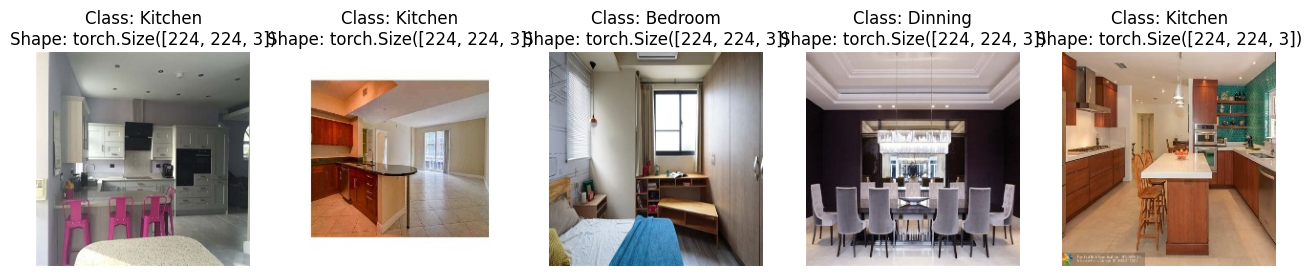

In [11]:
display_random_images(dataset=train_dataset,
                      classes=target_classes,
                      n=5,
                      seed=None)

In [15]:
#@title HyperParameter Optimization
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# print(model.parameters())

In [13]:
#@title CNN Training
import torch
from tqdm.auto import tqdm

epochs: int = 20

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set model to training mode.
model.train()

for epoch in tqdm(range(epochs)):
  # Initialize training loss accumulator for the epoch.
  train_loss: int = 0

  # Initialize training accuracy accumulator for the epoch.
  train_acc: int = 0

  # Iterate over the training dataloader.
  for i, (input, labels) in enumerate(train_dataloader):
    # Move tensors to configured device.
    input = input.to(device)
    labels = labels.to(device)

    # Forward pass: compute model predictions.
    outputs = model(input)

    # Compute the loss between model predictions
    # and ground truth labels.
    loss = criterion(outputs, labels)

    # Clear previously calculated gradient.
    optimizer.zero_grad()

    # Backward pass: compute gradients of loss w.r.t
    # model parameters.
    loss.backward()

    # Update model parameters using the optimizer.
    optimizer.step()

    # Accumulate the trainng loss for the current batch.
    train_loss += loss.item()

    # Get the predicted class labels
    _, preds = torch.max(outputs, 1)

    # Compute accuracy by comparing predictions with
    # true labels.
    train_acc += (preds == labels).float().mean()

  # Calculate training loss for the epoch.
  train_loss /= i+1

  # Calculate training accuracy for the epoch.
  train_acc /= i+1

  # Display epoch-wise training loss and accuracy.
  print("Epoch:  {}:   Training Loss:  {:.4f}:    Training Accuracy:  {:.4f}".format(epoch+1, train_loss, train_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  1:   Training Loss:  1.5357:    Training Accuracy:  0.3069
Epoch:  2:   Training Loss:  1.3684:    Training Accuracy:  0.4086
Epoch:  3:   Training Loss:  1.2210:    Training Accuracy:  0.4981
Epoch:  4:   Training Loss:  1.0691:    Training Accuracy:  0.5801
Epoch:  5:   Training Loss:  0.9526:    Training Accuracy:  0.6345
Epoch:  6:   Training Loss:  0.8195:    Training Accuracy:  0.6861
Epoch:  7:   Training Loss:  0.6799:    Training Accuracy:  0.7560
Epoch:  8:   Training Loss:  0.5410:    Training Accuracy:  0.8053
Epoch:  9:   Training Loss:  0.4265:    Training Accuracy:  0.8428
Epoch:  10:   Training Loss:  0.3316:    Training Accuracy:  0.8903
Epoch:  11:   Training Loss:  0.2548:    Training Accuracy:  0.9171
Epoch:  12:   Training Loss:  0.1861:    Training Accuracy:  0.9465
Epoch:  13:   Training Loss:  0.1529:    Training Accuracy:  0.9514
Epoch:  14:   Training Loss:  0.1004:    Training Accuracy:  0.9741
Epoch:  15:   Training Loss:  0.0811:    Training Accurac

In [14]:
#@title Testing The Model

# Context manager to disable gradient calculation.
with torch.no_grad():

  # Initialize variable to count the number of correct predictions.
  correct: int = 0

  # Initialize variable to count the total number of samples.
  total: int = 0

  # Iterate over the testloader.
  for images, labels in test_dataloader:

    # Forward pass: compute model predictions.
    outputs = model(images.to(device))

    # Fetch the index of the class with the highest probability.
    _, predicted = torch.max(outputs.data, 1)

    # Increment the total count by batch size.
    total += labels.size(0)

    # Count the number of correct predictions
    # in the batch.
    correct += (predicted == labels.to(device)).sum().item()

  # Print accuracy of the model on the validation set.
  print(f"Accuracy of network on the validation images: { 100 * correct / total}%")

Accuracy of network on the validation images: 47.484276729559745%


In [16]:
import torch
from tqdm.auto import tqdm

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

  ### Training
  train_loss, train_acc = 0, 0

  # Set model to train
  model.train()

  # Add loop to loop through training batch
  for batch, (X, y) in enumerate(dataloader):

    # Set data on target device
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)

    # Accumulate train loss
    train_loss += loss.item()

    # Optimize zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimize step
    optimizer.step()

    # Accumulate accuracy metrics
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # Divide train loss and train acc by length of train dataloader
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  # print(f"\nTrain Loss: {train_loss:.5f}  |  Train Accuracy: {train_acc:.2f}%")
  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):

  ### Testing
  test_loss, test_acc = 0, 0

  # Set model to eval mode
  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:

      # Put X and y data on GPU
      X = X.to(device)
      y = y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate the loss (accumulatively)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

  # Calculate test loss average per batch
  test_loss /= len(dataloader)

  # Calculate test accuracy average per batch
  test_acc /= len(dataloader)

  # # Print out what's happening
  # print(f"Test Loss: {test_loss:.5f}  |  Test Accuracy: {test_acc:.2f}%")
  return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device = device
          ):

    # Create an empty results dictionary
    results: dict = {
        "train_loss": list(),
        "train_acc": list(),
        "test_loss": list(),
        "test_acc": list()
    }

    # Create an optimization and evaluation loop
    # using train_step() and test_step()
    for epoch in tqdm(range(epochs)):

      print(f"\nEpoch: {epoch}\n---------")

      train_loss, train_acc  = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)

      test_loss, test_acc = test_step(model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

      # print out what's happening
      print(f"Epoch: {epoch}  |  Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}  |  Test Loss: {test_loss:.4f}  |  Test Acc: {test_acc:.4f}")

      # Update results dictionary above
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

    # Return results at the end of the epoch(s)
    return results


In [ ]:
from timeit import default_timer as timer

# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS: int = 15

# Start timer
start_time = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=criterion,
                      optimizer=optimizer,
                      epochs=NUM_EPOCHS,
                      device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total train time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
---------
Epoch: 0  |  Train Loss: 1.5448  |  Train Acc: 0.2821  |  Test Loss: 1.5051  |  Test Acc: 0.3152

Epoch: 1
---------
Epoch: 1  |  Train Loss: 1.4170  |  Train Acc: 0.3778  |  Test Loss: 1.6055  |  Test Acc: 0.2986

Epoch: 2
---------
Epoch: 2  |  Train Loss: 1.3462  |  Train Acc: 0.4197  |  Test Loss: 1.3656  |  Test Acc: 0.4144

Epoch: 3
---------
Epoch: 3  |  Train Loss: 1.2320  |  Train Acc: 0.4944  |  Test Loss: 1.2887  |  Test Acc: 0.4561

Epoch: 4
---------
Epoch: 4  |  Train Loss: 1.0879  |  Train Acc: 0.5698  |  Test Loss: 1.2040  |  Test Acc: 0.5080

Epoch: 5
---------
Epoch: 5  |  Train Loss: 0.9297  |  Train Acc: 0.6450  |  Test Loss: 1.2560  |  Test Acc: 0.4979

Epoch: 6
---------
Epoch: 6  |  Train Loss: 0.7441  |  Train Acc: 0.7250  |  Test Loss: 1.3391  |  Test Acc: 0.4913

Epoch: 7
---------
Epoch: 7  |  Train Loss: 0.5904  |  Train Acc: 0.7816  |  Test Loss: 1.3872  |  Test Acc: 0.5235

Epoch: 8
---------
Epoch: 8  |  Train Loss: 0.4338  |  Train Ac

In [15]:
from typing import Dict

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a result'd dictionary"""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out the number of epochs
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


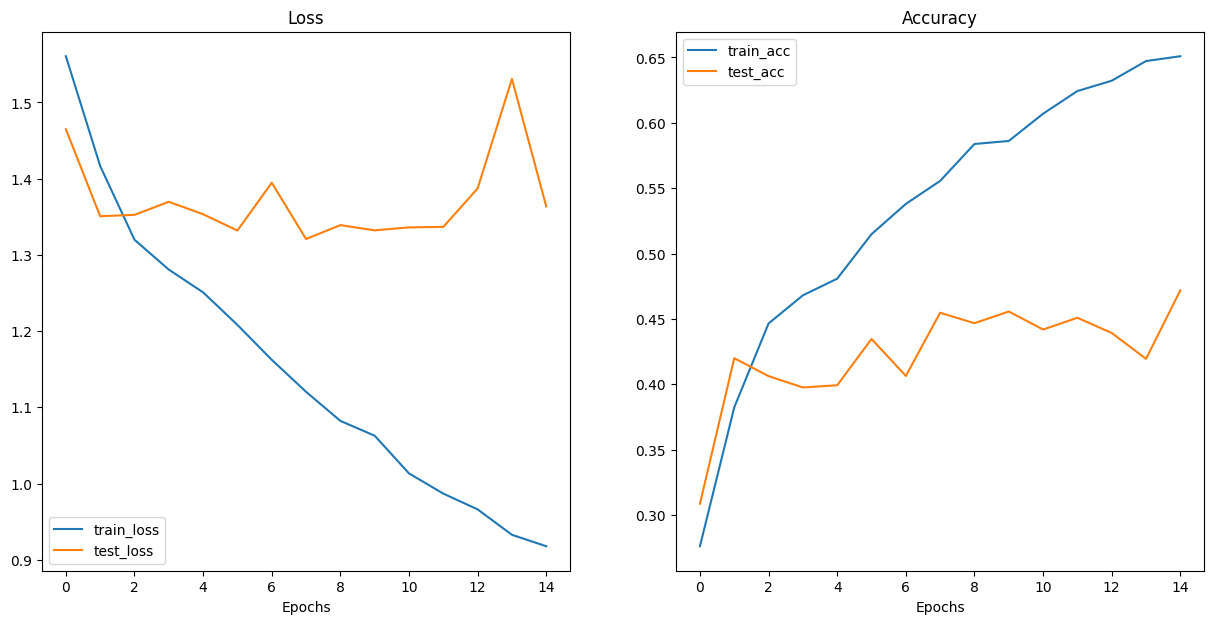

In [16]:
plot_loss_curves(results=model_results)

In [41]:
from timeit import default_timer as timer

# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS: int = 15

# Start timer
start_time = timer()

model_1_results = train(model=model_1,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=criterion,
                      optimizer=optimizer,
                      epochs=NUM_EPOCHS,
                      device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total train time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
---------
Epoch: 0  |  Train Loss: 1.6121  |  Train Acc: 0.1794  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 1
---------
Epoch: 1  |  Train Loss: 1.6118  |  Train Acc: 0.1801  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 2
---------
Epoch: 2  |  Train Loss: 1.6120  |  Train Acc: 0.1794  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 3
---------
Epoch: 3  |  Train Loss: 1.6123  |  Train Acc: 0.1794  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 4
---------
Epoch: 4  |  Train Loss: 1.6119  |  Train Acc: 0.1815  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 5
---------
Epoch: 5  |  Train Loss: 1.6121  |  Train Acc: 0.1794  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 6
---------
Epoch: 6  |  Train Loss: 1.6119  |  Train Acc: 0.1822  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 7
---------
Epoch: 7  |  Train Loss: 1.6124  |  Train Acc: 0.1787  |  Test Loss: 1.6051  |  Test Acc: 0.2010

Epoch: 8
---------
Epoch: 8  |  Train Loss: 1.6123  |  Train Ac

KeyboardInterrupt: 

In [2]:
import pathlib

modular_path = pathlib.Path("modular")

modular_path.mkdir(parents=True, exist_ok=True)

In [3]:
%%writefile modular/utils.py

import os
import torch
import random
import pathlib
from pathlib import Path
from typing import List, Dict
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


def create_train_test_split(data_dir: str,
                            target_classes: List[str],
                            train_split: float = 0.8,
                            test_split: float = 0.2) -> None:
  """
  This function splits images into `train` and `test` directory
  for data preparation.

  Args:
    data_dir: the directory where the data is located.

    target_classes: a list of labels for image classification.

    train_split: a float value that determines the amount of
                 images that will be allocated to the train directory.

    test_split: a float value that determines the amount of images
                that will be allocated to the test directory.

   Example usage:
      create_train_test_split(data_dir: 'path/to/the/image/data',
                              target_class: ['label_1', 'label_2', 'label_3'],
                              train_split: 0.9, test_split: 0.1)
  """

  # 1.) Create a train and test directory in
  # the House_Room_Dataset directory.

  training_dir = data_dir / "train"
  testing_dir = data_dir / "test"

  training_dir.mkdir(parents=True, exist_ok=True)
  testing_dir.mkdir(parents=True, exist_ok=True)

  # 2.) Move 80% of the images in each target directory
  # to the train dir and remaining 20% to the test dir.
  for label in target_classes:

    # Create target directory for each target
    # class in the train and test directories.
    train_destination = training_dir / label
    test_destination = testing_dir / label

    train_destination.mkdir(parents=True, exist_ok=True)
    test_destination.mkdir(parents=True, exist_ok=True)

    # Get the amount of images according
    # to the splits above.
    label_dir = data_dir / label
    label_images = os.listdir(label_dir)

    train_amount = round(len(list(label_images)) * train_split)
    test_amount = round(len(list(label_images)) * test_split)

    # Move the images to train and test destinations.
    for filename in label_images[:train_amount]:
      source = data_dir / label / filename

      if os.path.exists(source):
        os.rename(data_dir / label / filename, train_destination / filename)
        print(f"Moved '{filename}' to {train_destination}.")

    for filename in label_images[test_amount:]:
      source = data_dir / label / filename

      if os.path.exists(source):
        os.rename(data_dir / label / filename, test_destination / filename)
        print(f"Moved '{filename}' to {test_destination}.")


def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str) -> None:

  """
  Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved PyTorch model
                should include either ".pth" or ".pt"
                as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="tinyvgg_model.pth")
  """

  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model name should end with '.pth' and '.pt'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(), f=model_save_path)


def load_model(model: torch.nn.Module,
               model_save_path: str) -> torch.nn.Module:

  """
  Loads a PyTorch model from a directory where the model is saved.

  Args:
    model: A target PyTorch model to load.
    model_save_path: A directory to load the model from.

  Returns:
    A model with weights from a previously trained model.

  Example usage:
    model = LinearRegressionModelV2()
    loaded_model = load_model(model=model, model_save_path="models")
  """

  loaded_model = model.load_state_dict(torch.load(model_save_path, weights_only=True))
  return loaded_model


def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a result's dictionary

  Args:
    results: a dictionary with a trained model's train and test
             loss and accuracy metrics.

  Example usage:
    plot_loss_curves(results=model_results)

  """
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out the number of epochs
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  """
  Displays `n` number of images randomly chosen from given `dataset`

  Args:
    dataset: a dataset where the images will be randomly displayed.

    classes: a list of labels that will be used as a title of specific image.

    n: an interger value that represents the number of images that will be shown.

    display_shape: a boolean that displays the shape of a specfic image.

    seed: an interger value that create a random seed for
          reproducibility (meaning the same images will
          be shown each time this function executes).

  Example usage:
    display_random_images(dataset=train_dataset,
                          classes=target_classes,
                          n=5,
                          seed=None)
  """

  # Adjust display if n is too high
  if n > 10 or n <= 0 or type(n) is not int:
    n = 10
    display_shape = False
    print("For display purposes, 'n' shouldn't be larger than 10 and less than or equal to 0. Setting 'n' to 10 and removing shape display")

  # Set random seed for reproducibility
  if seed:
    random.seed(seed)

  # Get random sample index
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup matplotlib
  plt.figure(figsize=(16, 8))

  # Loop through sample indexes and plot them with matplotlib
  for i, target_sample in enumerate(random_samples_idx):
    target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

    # Adjust tensor dimensions for plotting
    target_image_adjust = target_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(target_image_adjust)
    plt.axis(False)

    if classes:
      title = f"Class: {classes[target_label]}"

      if display_shape:
        title = title + f"\nShape: {target_image_adjust.shape}"

    plt.title(title);


def display_image_count(training_dir: str,
                        testing_dir: str,
                        target_classes: List[str]):

  """
  Displays the number of images in the labels sub directory
  of the train and test directory.

  Args:
    training_dir: The location of the training image data.
    testing_dir: The location of the testing image data.
    target_classes: a list of labels for image classification.

  Example usage:
    display_image_count(training_dir='path/to/train/images',
                        testing_dir='path/to/test/images',
                        target_classes=['label_1', 'label_2', 'label_3'])
  """

  for label in target_classes:
    print(f"Training length for {label} images: {len(os.listdir(training_dir / label))}")
    print(f"Testing length for {label} images: {len(os.listdir(testing_dir / label))}")
    print("\n")


Overwriting modular/utils.py


In [9]:
data_dir

PosixPath('/root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset')

In [15]:
from modular.utils import create_train_test_split

create_train_test_split(data_dir=data_dir,
                        target_classes=["Bathroom", "Bedroom", "Dinning", "Kitchen", "Livingroom"])

Streaming output truncated to the last 5000 lines.
Moved 'bath_830.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_1198.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_168.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_1217.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_1055.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_187.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Dataset/train/Bathroom.
Moved 'bath_836.jpg' to /root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/House_Room_Data

In [8]:
from modular.utils import display_image_count

display_image_count(training_dir=training_dir,
                    testing_dir=testing_dir,
                    target_classes=target_classes)

Training length for Bathroom images: 485
Testing length for Bathroom images: 121


Training length for Bedroom images: 998
Testing length for Bedroom images: 250


Training length for Dinning images: 926
Testing length for Dinning images: 232


Training length for Kitchen images: 772
Testing length for Kitchen images: 193


Training length for Livingroom images: 1018
Testing length for Livingroom images: 255




In [9]:
%%writefile modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
from tqdm.auto import tqdm
from typing import List, Dict, Tuple

device: str = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device) -> Tuple[float, float]:
  """
  Trains a PyTorch model for a single epoch

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on ('cuda' or 'cpu').

  Returns:
    A Tuple consisting of training loss and training accuracy metrics.
  """

  ### Training
  train_loss, train_acc = 0, 0

  # Set model to train
  model.train()

  # Add loop to loop through training batch
  for batch, (X, y) in enumerate(dataloader):

    # Set data on target device
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)

    # Accumulate train loss
    train_loss += loss.item()

    # Optimize zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimize step
    optimizer.step()

    # Accumulate accuracy metrics
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # Divide train loss and train acc by length of train dataloader
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  # print(f"\nTrain Loss: {train_loss:.5f}  |  Train Accuracy: {train_acc:.2f}%")
  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device) -> Tuple[float, float]:
  """
  Test a PyTorch model for a single epoch.

  Turns a target PyTorch model to `eval` mode and then
  performs a forward pass on testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate the loss on the test data
    device: A target device to compute on ('cuda' or 'cpu').

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """

  ### Testing
  test_loss, test_acc = 0, 0

  # Set model to eval mode
  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:

      # Put X and y data on GPU
      X = X.to(device)
      y = y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate the loss (accumulatively)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

  # Calculate test loss average per batch
  test_loss /= len(dataloader)

  # Calculate test accuracy average per batch
  test_acc /= len(dataloader)

  # # Print out what's happening
  # print(f"Test Loss: {test_loss:.5f}  |  Test Accuracy: {test_acc:.2f}%")
  return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device = device
          ) -> Dict[str, List[float]]:
    """
    Trains and test a PyTorch model.

    Passes a target PyTorch model models through train_step() and test_step()
    functions for a number of epochs, training and testing the model in the
    same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      loss_fn: A PyTorch loss function to calculate the loss on both datasets.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on ('cuda' or 'cpu').

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for each
      epochs.

      In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]}

      For example if training for epoch=2: {train_loss: [2.0616, 1.0537],
                                            train_acc: [0.3945, 0.3945],
                                            test_loss: [1.2641, 1.5704],
                                            test_acc: [0.3400, 0.2973]}
    """

    # Create an empty results dictionary
    results: dict = {
        "train_loss": list(),
        "train_acc": list(),
        "test_loss": list(),
        "test_acc": list()
    }

    # Create an optimization and evaluation loop
    # using train_step() and test_step()
    for epoch in tqdm(range(epochs)):

      print(f"\nEpoch: {epoch}\n---------")

      train_loss, train_acc  = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)

      test_loss, test_acc = test_step(model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

      # print out what's happening
      print(f"Epoch: {epoch}  |  Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}  |  Test Loss: {test_loss:.4f}  |  Test Acc: {test_acc:.4f}")

      # Update results dictionary above
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

    # Return results at the end of the epoch(s)
    return results


Overwriting modular/engine.py


In [22]:
%%writefile modular/model.py

import torch
from torch import nn
from torch.nn import functional as F

"""
  Contains Python code to instantiate a PyTorch model instance.
"""

import torch
from torch import nn

class TinyVGG(nn.Module):
  """
  Creates the TinyVGG CNN architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    input_shape: An interger meaning the number of input channels.
    hidden_units: An interger indicating the number of hidden units between layers.
    output_shape: An interger for the number of output channels.

  Returns:
    A torch tensor with raw logit outputs that need to be converted to
    prediction probabilities using `torch.softmax()` and then converted
    into prediction labels using `torch.argmax()`.

    Example usage:
      x = torch.randn(3, 64, 64)

      model = TinyVGG(
        input_shape=3,
        hidden_units=10,
        output_shape=3
      )

      y_pred_logits = model(x)
  """

  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:

    super(TinyVGG, self).__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=2,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*14*14,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    # print(x.shape)

    x = self.conv_block_2(x)
    # print(x.shape)

    x = self.classifer(x)

    return x

    # return self.classifer(self.conv_block_2(self.conv_block_1(x))) # Uncomment to utilize operator fusion.


class PresenceCNN(nn.Module):
  """
  Creates A Custom CNN architecture.

  Args:
    input_shape: An interger meaning the number of input channels.
    hidden_units: An interger indicating the number of hidden units between layers.
    output_shape: An interger for the number of output channels.

  Returns:
    A torch tensor with raw logit outputs that need to be converted to
    prediction probabilities using `torch.softmax()` and then converted
    into prediction labels using `torch.argmax()`.

    Example usage:
      x = torch.randn(3, 64, 64)

      model = PresenceCNN(
        input_shape=3,
        hidden_units=10,
        output_shape=3
      )

      y_pred_logits = model(x)
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super(PresenceCNN, self).__init__()

    self.conv1_layer = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                           out_channels=hidden_units,
                           kernel_size=2,
                           stride=1,
                           padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv2_layer = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                           out_channels=hidden_units,
                           kernel_size=2,
                           stride=1,
                           padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv3_layer = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                           out_channels=hidden_units,
                           kernel_size=2,
                           stride=1,
                           padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*27*27, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, output_shape)
    )


  def forward(self, x):
    # x = self.conv1_layer(x)
    # print(x.shape)

    # x = self.conv2_layer(x)
    # print(x.shape)

    # x = self.conv3_layer(x)
    # print(x.shape)

    # x = self.classifer(x)

    # return x

    return self.classifer(
        self.conv3_layer(
            self.conv2_layer(
                self.conv1_layer(x)
            )
        )
    )


class CNN(nn.Module):
    """
    Creates A CNN architecture.

    Args:
      input_shape: An interger meaning the number of input channels.
      hidden_units: An interger indicating the number of hidden units between layers.
      output_shape: An interger for the number of output channels.

    Returns:
      A torch tensor with raw logit outputs that need to be converted to
      prediction probabilities using `torch.softmax()` and then converted
      into prediction labels using `torch.argmax()`.

      Example usage:
        x = torch.randn(3, 64, 64)

        model = CNN(
          input_shape=3,
          hidden_units=10,
          output_shape=3
        )

        y_pred_logits = model(x)
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):

        # Initialize the class as a subclass of nn.Module
        super(CNN, self).__init__()

        self.hidden_units = hidden_units

        # First convolutional layer
        self.conv1 = nn.Conv2d(input_shape, hidden_units, 2)  # 3 input channels, n hidden units, 2x2 kernel

        # First max pooling layer
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2

        # Second convolutional layer
        self.conv2 = nn.Conv2d(hidden_units, hidden_units, 2)  # n hidden units, n hidden units, 2x2 kernel

        # Second max pooling layer
        self.pool2 = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2

        # 3 Fully connected layers
        # Linear transformation to 120-dimensional space
        self.fc1 = nn.Linear(hidden_units * 55 * 55, 120)  # Flattening the input, hidden_units*27*27 input features, 120 output features

        # Linear transformation to 84-dimensional space
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features

        # Linear transformation to 10-dimensional space (output classes)
        self.fc3 = nn.Linear(84, output_shape)  # 84 input features, 10 output features (number of classes)

    def forward(self, x):
        # Operation 1: First convolutional layer with ReLU activation and max pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        # print(x.shape)

        # Operation 2: Second convolutional layer with ReLU activation and max pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        # print(x.shape)

        # Operation 3: Flattened Layer: Reshape for fully connected layer
        x = x.view(-1, self.hidden_units * 55 * 55)

        # Operation 4: First fully connected layer with ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Operation 5: Second fully connected layer with ReLU activation
        x = self.fc2(x)
        x = F.relu(x)

        # Operation 6: Output layer (fully connected) with raw scores for each class
        x = self.fc3(x)

        return x


Overwriting modular/model.py


In [11]:
%%writefile modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification.
"""

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS: int = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       train_transform: transforms.Compose,
                       test_transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int = NUM_WORKERS
    ):
  """
  Creates training and testing dataloaders

  Takes in a training and testing directory paths
  then turns them into PyTorch Datasets and finally
  into PyTorch Dataloaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transform to perform on your training and testing data.
    batch_size: An interger for the number of samples per batch in each of the DataLoaders.
    num_workers: An interger for the number of workers per DataLoaders.

  Returns:
    A tuple consisting of (train_dataloader, test_dataloader, class_names)
    Where class_names is a list of target classes.

    Example usage:
      train_dataloader, test_dataloader, class_names = create_dataloaders(
        train_dir='path/to/training/directory',
        test_dir='path/to/testing/directory',
        transform=transform,
        batch_size=32,
        num_workers=4
        )
  """

  # Create train and test Datasets using ImageFolder
  train_dataset = datasets.ImageFolder(
      root=train_dir,
      transform=train_transform,
      target_transform=None
  )

  test_dataset = datasets.ImageFolder(
      root=test_dir,
      transform=test_transform,
      target_transform=None
  )

  # Convert train and test datasets into DataLoaders
  train_dataloader = DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True
  )

  test_dataloader = DataLoader(
      dataset=test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True
  )

  # Create class names list
  class_names = train_dataset.classes

  return train_dataloader, test_dataloader, class_names

Overwriting modular/data_setup.py


In [21]:
%%writefile modular/transforms.py
"""
This file defines the training and testing transforms
"""
from torchvision import transforms

# Define the data transforms for data augmentation.
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

Overwriting modular/transforms.py


In [14]:
%%writefile modular/train.py

"""
Trains a PyTorch image classification model using device-agnostic code.
"""
import os
import torch

from torch import nn
from pathlib import Path
from model import PresenceCNN
from engine import train
from utils import save_model
from torchvision import transforms
from data_setup import create_dataloaders
from transforms import train_transform, test_transform

from timeit import default_timer as timer

# Set number of epochs
NUM_EPOCHS: int = 20

# Set batch size
BATCH_SIZE: int = 32

# Set number of workers
NUM_WORKERS: int = os.cpu_count()

# Set learning rate
LEARNING_RATE: float = 0.001

# Set the number of hidden units
HIDDEN_UNITS: int = 128

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup path to a data folder
data_path = Path("/root/.cache/kagglehub/datasets/robinreni/house-rooms-image-dataset/versions/1/")
image_path = data_path / "House_Room_Dataset/"

# Setup training and testing directory
training_dir = image_path / "train"
testing_dir = image_path / "test"


train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=training_dir,
                                                                    test_dir=testing_dir,
                                                                    train_transform=train_transform,
                                                                    test_transform=test_transform,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=NUM_WORKERS)

# Recreate instance of PresenceCNN
model = PresenceCNN(input_shape=3,
                    hidden_units=HIDDEN_UNITS,
                    output_shape=len(class_names)).to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Start the timer
start_time = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=NUM_EPOCHS,
                      device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total train time: {end_time-start_time:.3f}")

# Save model
save_model(model=model,
           target_dir="models",
           model_name="presence_cnn_model.pth")


Overwriting modular/train.py


In [23]:
!python modular/train.py

  0% 0/20 [00:00<?, ?it/s]
Epoch: 0
---------
Epoch: 0  |  Train Loss: 1.5597  |  Train Acc: 0.2661  |  Test Loss: 1.5113  |  Test Acc: 0.3148
  5% 1/20 [00:21<06:56, 21.93s/it]
Epoch: 1
---------
Epoch: 1  |  Train Loss: 1.4392  |  Train Acc: 0.3604  |  Test Loss: 1.4323  |  Test Acc: 0.3709
 10% 2/20 [00:43<06:30, 21.69s/it]
Epoch: 2
---------
Epoch: 2  |  Train Loss: 1.3254  |  Train Acc: 0.4316  |  Test Loss: 1.3565  |  Test Acc: 0.4394
 15% 3/20 [01:05<06:08, 21.68s/it]
Epoch: 3
---------
Epoch: 3  |  Train Loss: 1.2201  |  Train Acc: 0.4805  |  Test Loss: 1.2357  |  Test Acc: 0.4894
 20% 4/20 [01:27<05:50, 21.91s/it]
Epoch: 4
---------
Epoch: 4  |  Train Loss: 1.0869  |  Train Acc: 0.5634  |  Test Loss: 1.2274  |  Test Acc: 0.4899
 25% 5/20 [01:49<05:31, 22.11s/it]
Epoch: 5
---------
Epoch: 5  |  Train Loss: 0.9431  |  Train Acc: 0.6244  |  Test Loss: 1.2787  |  Test Acc: 0.4851
 30% 6/20 [02:11<05:09, 22.10s/it]
Epoch: 6
---------
Epoch: 6  |  Train Loss: 0.7998  |  Train Acc: 0